In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import os 
%matplotlib inline

In [4]:
def normalize(volume):
    # Normalize into range [0, 1]
    vol_max = volume.max()
    vol_min = volume.min()
    volume = (volume - vol_min) / (vol_max - vol_min)
    return volume

def morphology(seg_vol, kernel_size = (30, 30)):
    (z, h, w) = seg_vol.shape
    kernel1 =  cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    kernel2 =  cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    for i in range(z):
        axial = cv2.morphologyEx(seg_vol[i,:,:], cv2.MORPH_CLOSE, kernel1)
        seg_vol[i,:,:] = cv2.morphologyEx(axial, cv2.MORPH_OPEN, kernel2)
    for i in range(h):
        coronal = cv2.morphologyEx(seg_vol[:,i,:], cv2.MORPH_CLOSE, kernel1)
        seg_vol[:,i,:] = cv2.morphologyEx(coronal, cv2.MORPH_OPEN, kernel2)
    """for i in range(w):
        sagittal = cv2.morphologyEx(seg_vol[:,:,i], cv2.MORPH_CLOSE, kernel1)
        seg_vol[:,:,i] = cv2.morphologyEx(sagittal, cv2.MORPH_OPEN, kernel2)"""
    return seg_vol

def get_CC_largerThanTh(arr, thresh=8000,dbg=False):
    if dbg:
        dbg_CC(arr, prec=0.02)

    print('Applying Connected Component and take components with num pixels > max_pixels')
    labels = label(arr)
    print('Found ', labels.max(), 'labels')
    max_label = 0
    # Find largestCC
    large_labels = []
    for c_label in range(1, labels.max()+1):
        curr_num_bins = np.sum(np.where(labels == c_label, 1, 0))
        print(c_label, ':', curr_num_bins)
        if curr_num_bins > thresh:
            large_labels.append(c_label)
    print('Max CC label is: ', max_label)

    print('Num liver before CC: ', np.sum(arr))
    is_first = True
    for c_label in large_labels:
        if is_first:
            arr = np.where(labels == c_label, 1, 0)
            is_first = False
        else:
            arr[labels == c_label] = 1
    print('Num liver After CC: ',np.sum(arr) )

    if dbg:
        dbg_CC(arr,prec=0.02)
    return arr

def dbg_CC(arr, prec=0.01):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    pos = np.where(arr == 1)
    num_points = int(np.round(prec * len(pos[0])))
    indices = np.random.permutation(len(pos[0]))[0:num_points]

    ax.scatter(pos[0][indices], pos[1][indices], pos[2][indices])
    ax.view_init(elev=230., azim=360)
    plt.show()
    plt.ioff()
    # plt.waitforbuttonpress()
    plt.close()

def get_crop_coordinates(img, pad_size=2):
    """ input: binaty @D image
        output: crop coordinates of minimal "1" area with gap padding"""
    im_h, im_w = img.shape
    liver_m, liver_n = np.where(img >= 1)
    h_min = min(liver_m) - pad_size
    h_max = max(liver_m) + pad_size
    h = h_max - h_min + 1
    w_min = min(liver_n) - pad_size
    w_max = max(liver_n) + pad_size
    w = w_max - w_min + 1
    gap = abs(h - w)
    pad_l = int(np.ceil(gap / 2.))
    pad_r = int(np.floor(gap / 2.))
    if h > w:
        w_min -= pad_l
        w_max += pad_r
        if w_min < 0:
            w_min = 0
            w_max += (0 - w_min)
        if w_max > im_w:
            w_min -= w_max - im_w
            w_max = im_w
    if h < w:
        h_min -= pad_l
        h_max += pad_r
        if h_min < 0:
            h_min = 0
            h_max += (0 - h_min)
        if h_max > im_h:
            h_min -= h_max - im_h
            h_max = im_h

    return h_min, h_max, w_min, w_max

def get_crop_coordinates_3D(img_arr, pad_size=1,dbg=False):
    """ input: binaty 3D image
        output: global crop coordinates of minimal "1" area with gap padding"""
    im_d, im_h, im_w = img_arr.shape
    liver_z, liver_h, liver_w = np.where(img_arr >= 1)
    z_min = min(liver_z) - pad_size
    z_max = max(liver_z) + pad_size
    z = z_max - z_min + 1    
    h_min = min(liver_h) - pad_size
    h_max = max(liver_h) + pad_size
    h = h_max - h_min + 1
    w_min = min(liver_w) - pad_size
    w_max = max(liver_w) + pad_size
    w = w_max - w_min + 1
    gap = abs(h - w)
    pad_l = int(np.ceil(gap / 2.))
    pad_r = int(np.floor(gap / 2.))
    if h > w:
        w_min -= pad_l
        w_max += pad_r
        if w_min < 0:
            w_min = 0
            w_max += (0 - w_min)
        if w_max > im_w:
            w_min -= w_max - im_w
            w_max = im_w
    if h < w:
        h_min -= pad_l
        h_max += pad_r
        if h_min < 0:
            h_min = 0
            h_max += (0 - h_min)
        if h_max > im_h:
            h_min -= h_max - im_h
            h_max = im_h
    if dbg:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        num_points = int(np.round(0.02 * len(liver_z)))
        indices = np.random.permutation(len(liver_z))[0:num_points]
        # ax.scatter(liver_h, liver_w, liver_z)
        ax.scatter(liver_h[indices], liver_w[indices],liver_z[indices],s=0.8)
        ax.plot([h_min,h_max,h_max,h_min,h_min],[w_min, w_min,w_max, w_max,w_min], zs=int(im_d / 2), zdir='z',color='black')
        ax.view_init(elev=180., azim=360)
        plt.show()
        plt.ioff()
        plt.waitforbuttonpress()
        plt.close()

    return z_min, z_max, h_min, h_max, w_min, w_max

In [5]:
test_list = ['106']

In [6]:
slice_list = os.listdir("D:/Study/Thesis/LiTS/datasets-png/test/liver_seg/liver_seg")

In [7]:
z_list = []
for id in test_list:
    count = 0
    for filename in slice_list:
        if id == (filename.split('-')[1]).split('_')[0]:
            count += 1
    z_list.append(count)

In [8]:
seg_path = "D:/Study/Thesis/LiTS/datasets-png/test/liver_seg/liver_seg"

In [12]:
from skimage.measure import label

In [13]:

liver_seg = np.zeros((z_list[0], 512, 512)).astype('uint8')
for j in range(z_list[0]):
    liver_seg[j] = cv2.imread(os.path.join(seg_path, f'segmentation-{test_list[0]}_{j}.png'), cv2.IMREAD_GRAYSCALE)
    
liver_seg = liver_seg / 255
liver_seg[liver_seg >= 0.5] = 1
liver_seg[liver_seg < 0.5] = 0
(z, h, w) = liver_seg.shape
0
    
seg_liver_CC = get_CC_largerThanTh(np.where(liver_seg > 0, 1, 0), dbg=False)
# 3-D Crop coordinates
(z1, z2, h1, h2, w1, w2) = get_crop_coordinates_3D(seg_liver_CC, dbg=False)

Applying Connected Component and take components with num pixels > max_pixels
Found  1 labels
1 : 2312280
Max CC label is:  0
Num liver before CC:  2312280
Num liver After CC:  2312280


In [15]:
print(h1,h2,w1,w2)

146 403 98 355


In [16]:
tumor_path = "D:/Users/ASUS/Downloads/Compressed/tumor_result/tumor_results"
save_path = "D:/Users/ASUS/Downloads/Compressed/tumor_result/New folder"

In [17]:
for i, filename in enumerate(os.listdir(tumor_path)):
  arr = np.zeros((512,512)).astype('uint8')
  tumor_seg = cv2.imread(os.path.join(tumor_path, filename), cv2.IMREAD_GRAYSCALE)
  tumor_seg = cv2.resize(tumor_seg, (257,257), interpolation=cv2.INTER_NEAREST)
  arr[h1:h2,w1:w2] = tumor_seg
  cv2.imwrite(os.path.join(save_path, filename), arr)

In [18]:
def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret

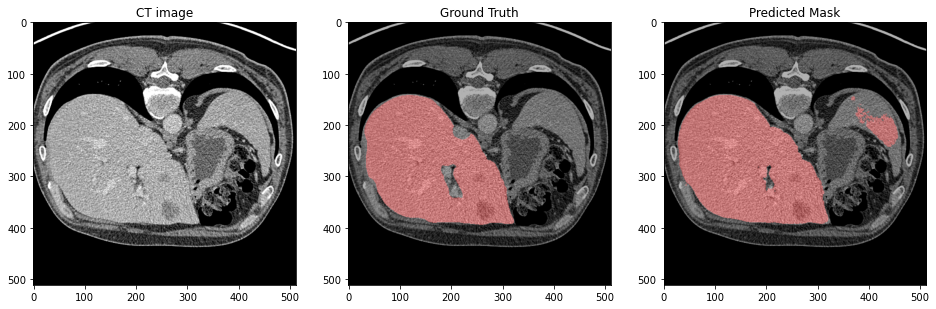

In [26]:
image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/ct/ct/volume-101_540.png")
predict_image = cv2.imread("D:/Users/ASUS/Downloads/Compressed/liver_result/liver_results/liver-101_540.png")
mask_image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/liver_seg/liver_seg/segmentation-101_540.png")

fig, axs = plt.subplots(1,3, figsize=(16, 16))

axs[0].set_title("CT image")
axs[0].imshow(image)
axs[1].set_title("Ground Truth")
axs[1].imshow(add_colored_mask(image, mask_image))
axs[2].set_title("Predicted Mask")
axs[2].imshow(add_colored_mask(image, predict_image))

In [27]:
fig.savefig('D:/Study/Thesis/Report/Images/predictR2U.png', dpi = 512)

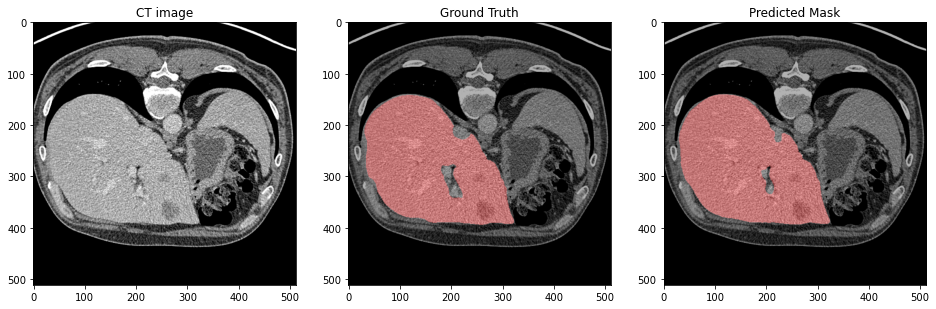

In [29]:
image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/ct/ct/volume-101_540.png")
predict_image = cv2.imread("D:/Study/Thesis/LiTS/LiverSeg-UNet-ResNet50-20220528T101045Z-001/LiverSeg-UNet-ResNet50/segmentation-101_540.png")
mask_image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/liver_seg/liver_seg/segmentation-101_540.png")

fig, axs = plt.subplots(1,3, figsize=(16, 16))

axs[0].set_title("CT image")
axs[0].imshow(image)
axs[1].set_title("Ground Truth")
axs[1].imshow(add_colored_mask(image, mask_image))
axs[2].set_title("Predicted Mask")
axs[2].imshow(add_colored_mask(image, predict_image))

In [30]:
fig.savefig('D:/Study/Thesis/Report/Images/LiversegResNet.png', dpi = 512)

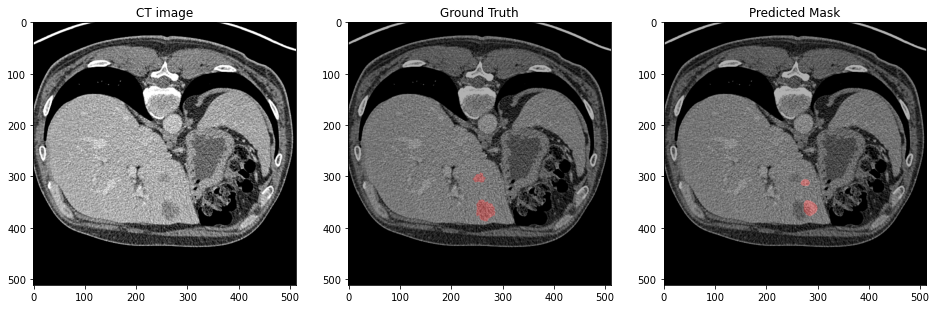

In [35]:
image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/ct/ct/volume-101_540.png")
predict_image = cv2.imread("D:/Users/ASUS/Downloads/Compressed/liver_result/liver_results/liver-101_540.png")
predict_tumor = cv2.imread("D:/Users/ASUS/Downloads/Compressed/tumor_result/New folder/tumor-101_540.png")
predict_tumor[predict_image == 0] = 0
mask_image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/tumor_seg/tumor_seg/segmentation-101_540.png")

fig, axs = plt.subplots(1,3, figsize=(16, 16))

axs[0].set_title("CT image")
axs[0].imshow(image)
axs[1].set_title("Ground Truth")
axs[1].imshow(add_colored_mask(image, mask_image))
axs[2].set_title("Predicted Mask")
axs[2].imshow(add_colored_mask(image, predict_tumor))

In [34]:
fig.savefig('D:/Study/Thesis/Report/Images/TumorsegR2UNet.png', dpi = 512)

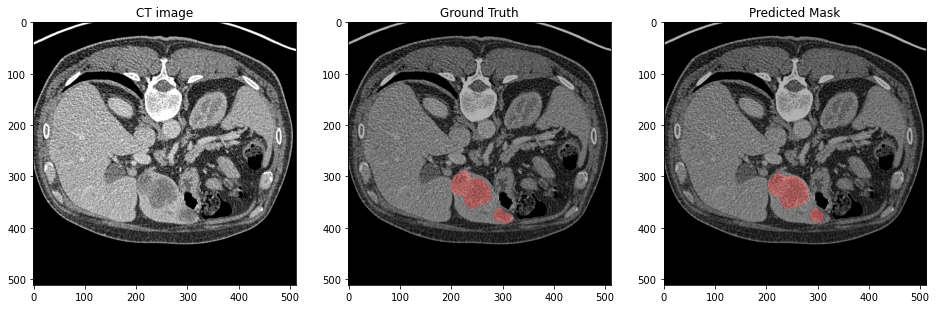

In [37]:
image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/ct/ct/volume-101_500.png")

predict_tumor = cv2.imread("D:/Study/Thesis/LiTS/Final-result/TumorSeg/segmentation-101_500.png")

mask_image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/tumor_seg/tumor_seg/segmentation-101_500.png")

fig, axs = plt.subplots(1,3, figsize=(16, 16))

axs[0].set_title("CT image")
axs[0].imshow(image)
axs[1].set_title("Ground Truth")
axs[1].imshow(add_colored_mask(image, mask_image))
axs[2].set_title("Predicted Mask")
axs[2].imshow(add_colored_mask(image, predict_tumor))

In [38]:
fig.savefig('D:/Study/Thesis/Report/Images/TumorsegResNet.png', dpi = 512)

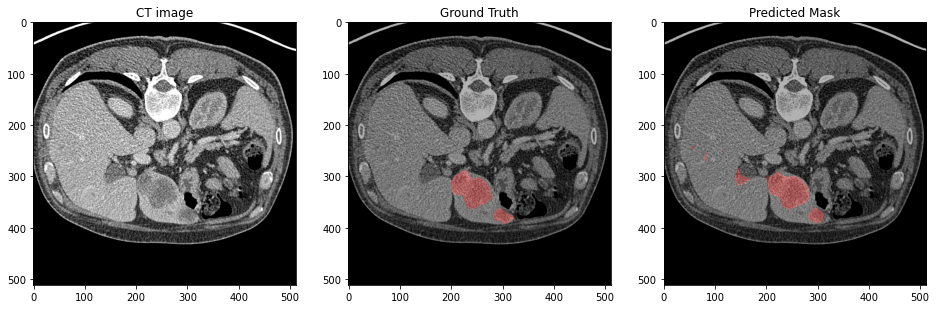

In [39]:
image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/ct/ct/volume-101_500.png")

predict_tumor = cv2.imread("D:/Study/Thesis/LiTS/Final-result/Multiplane/segmentation-101_500.png")

mask_image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/tumor_seg/tumor_seg/segmentation-101_500.png")

fig, axs = plt.subplots(1,3, figsize=(16, 16))

axs[0].set_title("CT image")
axs[0].imshow(image)
axs[1].set_title("Ground Truth")
axs[1].imshow(add_colored_mask(image, mask_image))
axs[2].set_title("Predicted Mask")
axs[2].imshow(add_colored_mask(image, predict_tumor))

In [40]:
fig.savefig('D:/Study/Thesis/Report/Images/TumorsegMulti.png', dpi = 512)

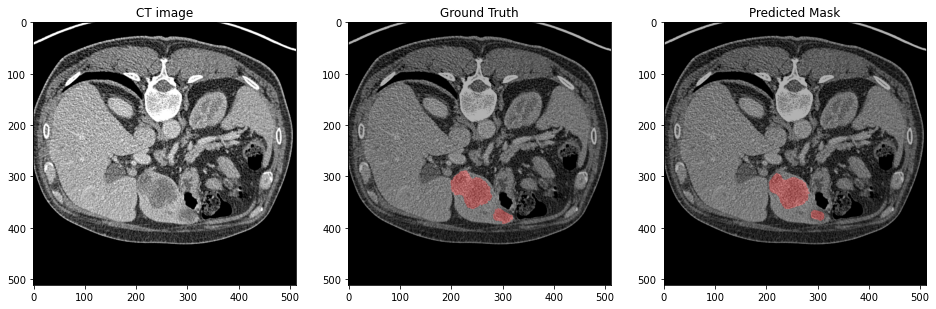

In [46]:
image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/ct/ct/volume-101_500.png")

predict_tumor = cv2.imread("D:/Study/Thesis/LiTS/Final-result/Polar/segmentation-101_500.png")

mask_image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/tumor_seg/tumor_seg/segmentation-101_500.png")

fig, axs = plt.subplots(1,3, figsize=(16, 16))

axs[0].set_title("CT image")
axs[0].imshow(image)
axs[1].set_title("Ground Truth")
axs[1].imshow(add_colored_mask(image, mask_image))
axs[2].set_title("Predicted Mask")
axs[2].imshow(add_colored_mask(image, predict_tumor))

In [47]:
fig.savefig('D:/Study/Thesis/Report/Images/TumorsegPolar.png', dpi = 512)

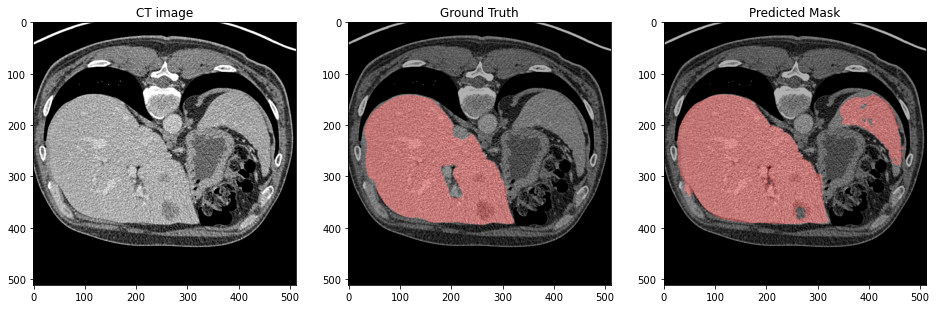

In [48]:
image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/ct/ct/volume-101_540.png")

predict_tumor = cv2.imread("D:/Study/Thesis/LiTS/Final-result/LiverSegUNet/segmentation-101_540.png")

mask_image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/liver_seg/liver_seg/segmentation-101_540.png")

fig, axs = plt.subplots(1,3, figsize=(16, 16))

axs[0].set_title("CT image")
axs[0].imshow(image)
axs[1].set_title("Ground Truth")
axs[1].imshow(add_colored_mask(image, mask_image))
axs[2].set_title("Predicted Mask")
axs[2].imshow(add_colored_mask(image, predict_tumor))

In [49]:
fig.savefig('D:/Study/Thesis/Report/Images/LiverSEGUNET.png', dpi = 512)

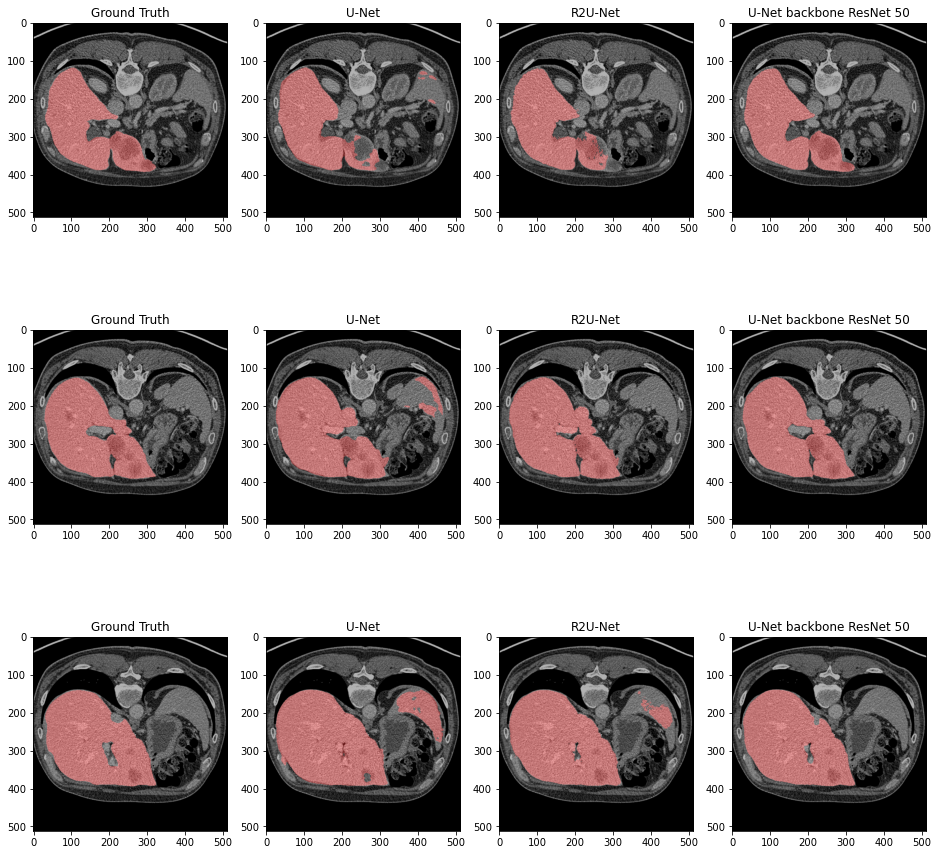

In [50]:
image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/ct/ct/volume-101_500.png")
r2unet = cv2.imread("D:/Users/ASUS/Downloads/Compressed/liver_result/liver_results/liver-101_500.png")
axial = cv2.imread("D:/Study/Thesis/LiTS/LiverSeg-UNet-ResNet50-20220528T101045Z-001/LiverSeg-UNet-ResNet50/segmentation-101_500.png")
multi = cv2.imread("D:/Study/Thesis/LiTS/Final-result/Multiplane/segmentation-101_500.png")
polar = cv2.imread("D:/Study/Thesis/LiTS/Final-result/Polar/segmentation-101_500.png")
mask_image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/liver_seg/liver_seg/segmentation-101_500.png")

fig, axs = plt.subplots(3, 4, figsize=(16, 16))

axs[0, 0].set_title("Ground Truth")
axs[0, 0].imshow(add_colored_mask(image, mask_image))
axs[0, 1].set_title("U-Net")
axs[0, 1].imshow(add_colored_mask(image, unet))
axs[0, 2].set_title("R2U-Net")
axs[0, 2].imshow(add_colored_mask(image, r2unet))
axs[0, 3].set_title("U-Net backbone ResNet 50")
axs[0, 3].imshow(add_colored_mask(image, resnet))

image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/ct/ct/volume-101_520.png")
unet = cv2.imread("D:/Study/Thesis/LiTS/Final-result/LiverSegUNet/segmentation-101_520.png")
r2unet = cv2.imread("D:/Users/ASUS/Downloads/Compressed/liver_result/liver_results/liver-101_520.png")
resnet = cv2.imread("D:/Study/Thesis/LiTS/LiverSeg-UNet-ResNet50-20220528T101045Z-001/LiverSeg-UNet-ResNet50/segmentation-101_520.png")
mask_image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/liver_seg/liver_seg/segmentation-101_520.png")



axs[1, 0].set_title("Ground Truth")
axs[1, 0].imshow(add_colored_mask(image, mask_image))
axs[1, 1].set_title("U-Net")
axs[1, 1].imshow(add_colored_mask(image, unet))
axs[1, 2].set_title("R2U-Net")
axs[1, 2].imshow(add_colored_mask(image, r2unet))
axs[1, 3].set_title("U-Net backbone ResNet 50")
axs[1, 3].imshow(add_colored_mask(image, resnet))

image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/ct/ct/volume-101_540.png")
unet = cv2.imread("D:/Study/Thesis/LiTS/Final-result/LiverSegUNet/segmentation-101_540.png")
r2unet = cv2.imread("D:/Users/ASUS/Downloads/Compressed/liver_result/liver_results/liver-101_540.png")
resnet = cv2.imread("D:/Study/Thesis/LiTS/LiverSeg-UNet-ResNet50-20220528T101045Z-001/LiverSeg-UNet-ResNet50/segmentation-101_540.png")
mask_image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/liver_seg/liver_seg/segmentation-101_540.png")



axs[2, 0].set_title("Ground Truth")
axs[2, 0].imshow(add_colored_mask(image, mask_image))
axs[2, 1].set_title("U-Net")
axs[2, 1].imshow(add_colored_mask(image, unet))
axs[2, 2].set_title("R2U-Net")
axs[2, 2].imshow(add_colored_mask(image, r2unet))
axs[2, 3].set_title("U-Net backbone ResNet 50")
axs[2, 3].imshow(add_colored_mask(image, resnet))

In [51]:
fig.savefig('D:/Study/Thesis/Report/Images/compare.png', dpi = 512)

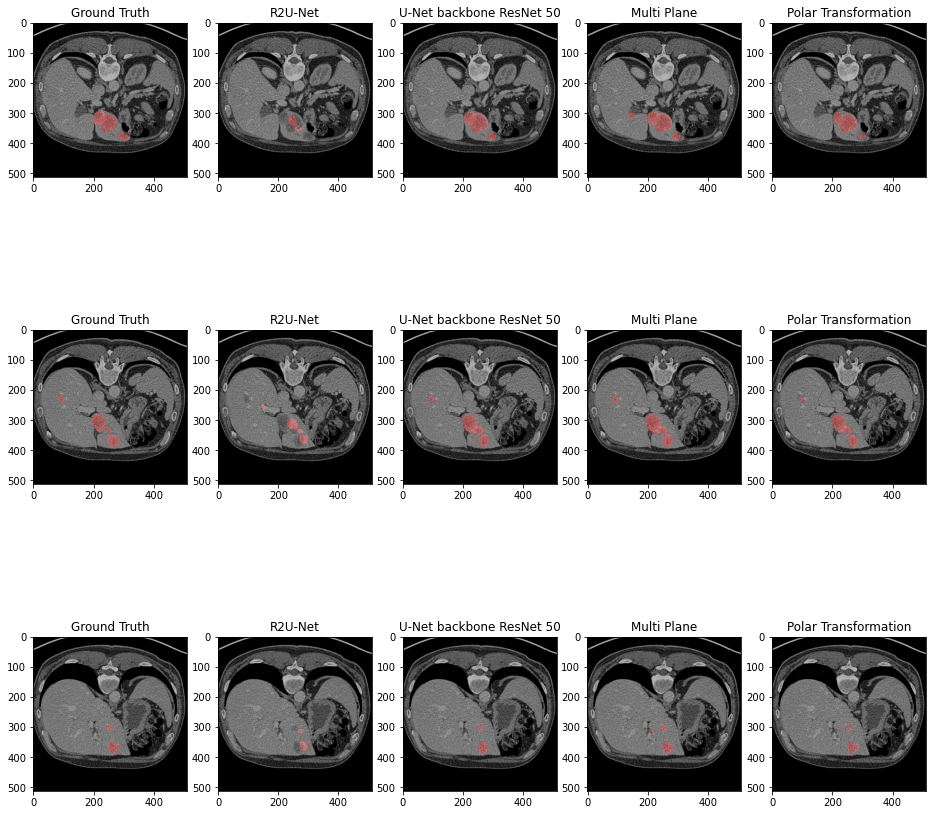

In [52]:
image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/ct/ct/volume-101_500.png")
r2unetliver = cv2.imread("D:/Users/ASUS/Downloads/Compressed/liver_result/liver_results/liver-101_500.png")
r2unet = cv2.imread("D:/Users/ASUS/Downloads/Compressed/tumor_result/New folder/tumor-101_500.png")
r2unet[r2unetliver == 0] = 0
axial = cv2.imread("D:/Study/Thesis/LiTS/Final-result/TumorSeg/segmentation-101_500.png")
multi = cv2.imread("D:/Study/Thesis/LiTS/Final-result/Multiplane/segmentation-101_500.png")
polar = cv2.imread("D:/Study/Thesis/LiTS/Final-result/Polar/segmentation-101_500.png")
mask_image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/tumor_seg/tumor_seg/segmentation-101_500.png")

fig, axs = plt.subplots(3, 5, figsize=(16, 16))

axs[0, 0].set_title("Ground Truth")
axs[0, 0].imshow(add_colored_mask(image, mask_image))
axs[0, 1].set_title("R2U-Net")
axs[0, 1].imshow(add_colored_mask(image, r2unet))
axs[0, 2].set_title("U-Net backbone ResNet 50")
axs[0, 2].imshow(add_colored_mask(image, axial))
axs[0, 3].set_title("Multi Plane")
axs[0, 3].imshow(add_colored_mask(image, multi))
axs[0, 4].set_title("Polar Transformation")
axs[0, 4].imshow(add_colored_mask(image, polar))

image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/ct/ct/volume-101_520.png")
r2unetliver = cv2.imread("D:/Users/ASUS/Downloads/Compressed/liver_result/liver_results/liver-101_520.png")
r2unet = cv2.imread("D:/Users/ASUS/Downloads/Compressed/tumor_result/New folder/tumor-101_520.png")
r2unet[r2unetliver == 0] = 0
axial = cv2.imread("D:/Study/Thesis/LiTS/Final-result/TumorSeg/segmentation-101_520.png")
multi = cv2.imread("D:/Study/Thesis/LiTS/Final-result/Multiplane/segmentation-101_520.png")
polar = cv2.imread("D:/Study/Thesis/LiTS/Final-result/Polar/segmentation-101_520.png")
mask_image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/tumor_seg/tumor_seg/segmentation-101_520.png")


axs[1, 0].set_title("Ground Truth")
axs[1, 0].imshow(add_colored_mask(image, mask_image))
axs[1, 1].set_title("R2U-Net")
axs[1, 1].imshow(add_colored_mask(image, r2unet))
axs[1, 2].set_title("U-Net backbone ResNet 50")
axs[1, 2].imshow(add_colored_mask(image, axial))
axs[1, 3].set_title("Multi Plane")
axs[1, 3].imshow(add_colored_mask(image, multi))
axs[1, 4].set_title("Polar Transformation")
axs[1, 4].imshow(add_colored_mask(image, polar))

image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/ct/ct/volume-101_540.png")
r2unetliver = cv2.imread("D:/Users/ASUS/Downloads/Compressed/liver_result/liver_results/liver-101_540.png")
r2unet = cv2.imread("D:/Users/ASUS/Downloads/Compressed/tumor_result/New folder/tumor-101_540.png")
r2unet[r2unetliver == 0] = 0
axial = cv2.imread("D:/Study/Thesis/LiTS/Final-result/TumorSeg/segmentation-101_540.png")
multi = cv2.imread("D:/Study/Thesis/LiTS/Final-result/Multiplane/segmentation-101_540.png")
polar = cv2.imread("D:/Study/Thesis/LiTS/Final-result/Polar/segmentation-101_540.png")
mask_image = cv2.imread("D:/Study/Thesis/LiTS/datasets-png/test/tumor_seg/tumor_seg/segmentation-101_540.png")


axs[2, 0].set_title("Ground Truth")
axs[2, 0].imshow(add_colored_mask(image, mask_image))
axs[2, 1].set_title("R2U-Net")
axs[2, 1].imshow(add_colored_mask(image, r2unet))
axs[2, 2].set_title("U-Net backbone ResNet 50")
axs[2, 2].imshow(add_colored_mask(image, axial))
axs[2, 3].set_title("Multi Plane")
axs[2, 3].imshow(add_colored_mask(image, multi))
axs[2, 4].set_title("Polar Transformation")
axs[2, 4].imshow(add_colored_mask(image, polar))

In [53]:
fig.savefig('D:/Study/Thesis/Report/Images/comparetumor.png', dpi = 512)